<a href="https://colab.research.google.com/github/natthanich/EfficientNet_Classification_DeepTooth/blob/main/%E0%B8%82%E0%B8%AD%E0%B8%87%E0%B8%A3%E0%B8%B8%E0%B9%88%E0%B8%99%E0%B8%9E%E0%B8%B5%E0%B9%88_Class_2_Train_2e_4_Freeze.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#เรียกใช้ CSV

In [1]:
import pandas as pd
import shutil

In [2]:
#เชื่อม google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


#Imports

In [3]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
import os
import glob
import shutil
import sys
import numpy as np
from skimage.io import imread
import matplotlib.pyplot as plt
from IPython.display import Image
%matplotlib inline

#กำหนดค่าพารามิเตอร์


In [4]:
batch_size = 16
width = 150
height = 150
epochs = 250
# NUM_TRAIN = 2850
# NUM_TEST = 950
dropout_rate = 0.2
input_shape = (height, width, 3)

#Clone efficientnet repo


In [5]:
#ดึงข้อมูลใน Github มาใช้
import os
%cd /content
if not os.path.isdir("efficientnet_keras_transfer_learning"):
 !git clone https://github.com/Wanita-8943/efficientnet_keras_transfer_learning
%cd efficientnet_keras_transfer_learning/


/content
Cloning into 'efficientnet_keras_transfer_learning'...
remote: Enumerating objects: 1100, done.
remote: Counting objects: 100% (263/263), done.
remote: Compressing objects: 100% (142/142), done.
remote: Total 1100 (delta 133), reused 241 (delta 121), pack-reused 837
Receiving objects: 100% (1100/1100), 14.10 MiB | 14.03 MiB/s, done.
Resolving deltas: 100% (630/630), done.
/content/efficientnet_keras_transfer_learning


In [6]:
# Options: EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3
# Higher the number, the more complex the model is.
from efficientnet import EfficientNetB0 as Net
from efficientnet import center_crop_and_resize, preprocess_input

# load model

In [8]:
import sys
sys.path.append('/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_tooth/Model/EfficientNet_Class_ตามรุ่นพี่/1_1_2e-4_250_Freeze.h5')

from efficientnet.layers import Swish, DropConnect
from efficientnet.model import ConvKernalInitializer
from tensorflow.keras.utils import get_custom_objects

get_custom_objects().update({
    'ConvKernalInitializer': ConvKernalInitializer,
    'Swish': Swish,
    'DropConnect':DropConnect
})

In [9]:
#load model
from tensorflow.keras.models import load_model
model = load_model('/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_tooth/Model/EfficientNet_Class_ตามรุ่นพี่/1_1_2e-4_250_Freeze.h5')
height = width = model.input_shape[1]


In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b0 (Functional  (None, 5, 5, 1280)       4049564   
 )                                                               
                                                                 
 gap (GlobalMaxPooling2D)    (None, 1280)              0         
                                                                 
 dropout_out (Dropout)       (None, 1280)              0         
                                                                 
 fc_out (Dense)              (None, 2)                 2562      
                                                                 
Total params: 4,052,126
Trainable params: 2,562
Non-trainable params: 4,049,564
_________________________________________________________________


#สร้างโฟลเดอร์ Train Valodation และ Test

In [11]:
df = pd.read_csv (r'/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_tooth/table_cut_images/table_train_10Fold_forGender.csv')
df

,Unnamed: 0,Age(year),Gender,Folder_type,Folder_name,Path_Name,Filename,Fold,Gender_Class
0,0,7,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,V1.jpg,2,0
1,1,7,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,FlipV1.jpg,4,0
2,2,7,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,V2.jpg,10,0
3,3,7,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,FlipV2.jpg,9,0
4,4,7,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,V3.jpg,10,0
...,...,...,...,...,...,...,...,...,...
4184,4184,25,M,Normal,Rt,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,J375.jpg,3,1
4185,4185,25,M,Normal,Rt,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,J437.jpg,5,1
4186,4186,25,M,Normal,Rt,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,J480.jpg,5,1
4187,4187,25,M,Normal,Rt,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,J491.jpg,6,1


In [12]:
df = df.iloc[:,1:]

In [13]:
df['Gender_Cate'] = df['Gender'].map({'F': 'Female', 'M': 'Male'})

In [15]:
val = df[df['Fold']==2]
val

,Age(year),Gender,Folder_type,Folder_name,Path_Name,Filename,Fold,Gender_Class,Gender_Cate
0,7,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,V1.jpg,2,0,Female
10,7,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,V13.jpg,2,0,Female
14,7,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,V17.jpg,2,0,Female
15,7,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,FlipV17.jpg,2,0,Female
30,7,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,V38.jpg,2,0,Female
...,...,...,...,...,...,...,...,...,...
4157,25,M,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,J476.jpg,2,1,Male
4159,25,M,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,J478.jpg,2,1,Male
4162,25,M,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,FlipJ492.jpg,2,1,Male
4169,25,M,Normal,Lt,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,FlipJ179.jpg,2,1,Male


In [16]:
train = df[~df['Fold'].isin(val['Fold'])]
train

,Age(year),Gender,Folder_type,Folder_name,Path_Name,Filename,Fold,Gender_Class,Gender_Cate
1,7,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,FlipV1.jpg,4,0,Female
2,7,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,V2.jpg,10,0,Female
3,7,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,FlipV2.jpg,9,0,Female
4,7,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,V3.jpg,10,0,Female
5,7,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,FlipV3.jpg,9,0,Female
...,...,...,...,...,...,...,...,...,...
4184,25,M,Normal,Rt,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,J375.jpg,3,1,Male
4185,25,M,Normal,Rt,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,J437.jpg,5,1,Male
4186,25,M,Normal,Rt,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,J480.jpg,5,1,Male
4187,25,M,Normal,Rt,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,J491.jpg,6,1,Male


In [17]:
DATA_PATH = "/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_tooth/Data_Cut_images/Normal"
os.chdir(DATA_PATH)
#train_dir = os.path.join(DATA_PATH, 'train')
#print(train_dir)
#validation_dir = os.path.join(DATA_PATH, 'validation')
#print(validation_dir)


#Train

In [18]:
# Train ด้วย ImageDataGenerator ของ Keras ซึ่งจะเพิ่มข้อมูลเสริมระหว่างการฝึกเพื่อลดโอกาสเกิด overfitting
#overfitting เกิดจากข้อมูลที่ซับซ้อนกันเกินไป
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255, #โมเดลส่วนใหญ่ต้องใช้ RGB ในช่วง 0–1
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

In [19]:
train_generator = train_datagen.flow_from_dataframe(
        dataframe = train,
        # This is the target directory #ไดเรกเป้าหมาย
        directory = DATA_PATH,
        x_col = 'Path_Name',
        y_col = 'Gender_Cate',
        # รูปภาพทั้งหมดจะถูกปรับขนาดตามความสูงและความกว้างของเป้าหมาย
        target_size=(height, width),
        batch_size=batch_size,
        # Since we use categorical_crossentropy loss, we need categorical labels
        #เนื่องจากเราใช้ categorical_crossentropy loss เราจึงต้องมีป้ายกำกับตามหมวดหมู่
        class_mode='categorical')

validation_generator = test_datagen.flow_from_dataframe( #การดึงภาพจาก Directory มาเข้าโมเดล
        dataframe = val,
        directory = DATA_PATH,
        x_col = 'Path_Name',
        y_col = 'Gender_Cate',
        target_size=(height, width),
        batch_size=batch_size,
        class_mode='categorical')

Found 3797 validated image filenames belonging to 2 classes.
Found 392 validated image filenames belonging to 2 classes.


In [20]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=2e-4),
              metrics=['acc'])
history = model.fit_generator(
      train_generator,
      steps_per_epoch= len(train) //batch_size,
      epochs=epochs,
      validation_data=validation_generator,
      validation_steps= len(val) //batch_size,
      verbose=1,
      use_multiprocessing=True,
      workers=4)

<ipython-input-20-4a74e14b12d4>:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/250
237/237 [==============================] - 818s 3s/step - loss: 0.6312 - acc: 0.6527 - val_loss: 0.5126 - val_acc: 0.7448
Epoch 2/250
237/237 [==============================] - 17s 72ms/step - loss: 0.6259 - acc: 0.6620 - val_loss: 0.5275 - val_acc: 0.7266
Epoch 3/250
237/237 [==============================] - 17s 72ms/step - loss: 0.6228 - acc: 0.6633 - val_loss: 0.5023 - val_acc: 0.7760
Epoch 4/250
237/237 [==============================] - 18s 75ms/step - loss: 0.6239 - acc: 0.6644 - val_loss: 0.5014 - val_acc: 0.7734
Epoch 5/250
237/237 [==============================] - 17s 72ms/step - loss: 0.6187 - acc: 0.6657 - val_loss: 0.5430 - val_acc: 0.7266
Epoch 6/250
237/237 [==============================] - 18s 73ms/step - loss: 0.6303 - acc: 0.6638 - val_loss: 0.5089 - val_acc: 0.7604
Epoch 7/250
237/237 [==============================] - 18s 73ms/step - loss: 0.6272 - acc: 0.6530 - val_loss: 0.4986 - val_acc: 0.7656
Epoch 8/250
237/237 [==============================] - 1

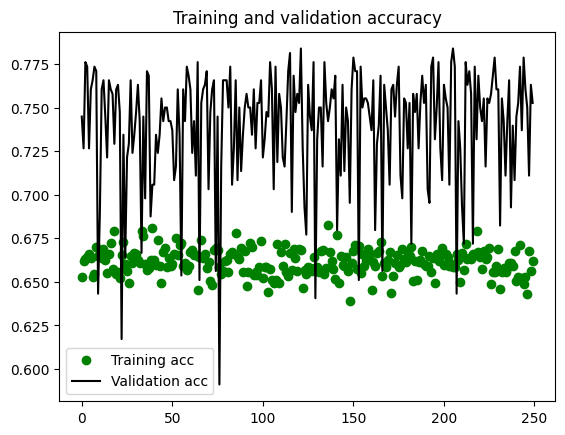

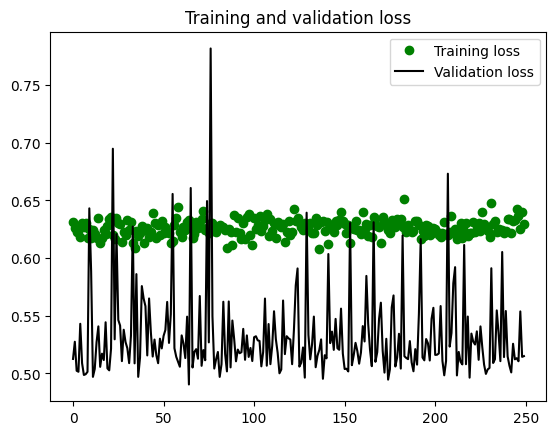

In [21]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_x = range(len(acc))

plt.plot(epochs_x, acc, 'go', label='Training acc')
plt.plot(epochs_x, val_acc, 'k', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs_x, loss, 'go', label='Training loss')
plt.plot(epochs_x, val_loss, 'k', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

#Download the model


In [22]:
os.makedirs('/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_tooth/Model', exist_ok=True)
model.save('/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_tooth/Model/EfficientNet_Class_ตามรุ่นพี่/1_2_2e-4_250_Freeze.h5')